In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
 

In [2]:
data = pd.read_csv('comp_occur.csv')

In [3]:
# Separate features and labels
features = data[[f'V{i}' for i in range(1, 40)]]
labels = data['Fold']

# Label encode the target
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [4]:
# PCA
pca = PCA(n_components=15)
pca_result = pca.fit_transform(scaled_features)

In [5]:
# UMAP
umap_model2 = umap.UMAP(n_components=2,  metric='euclidean')
umap_pca_2 = umap_model2.fit_transform(pca_result)

In [6]:
umap_model15 = umap.UMAP(n_components=2,  metric='euclidean')
umap15 = umap_model15.fit_transform(scaled_features)

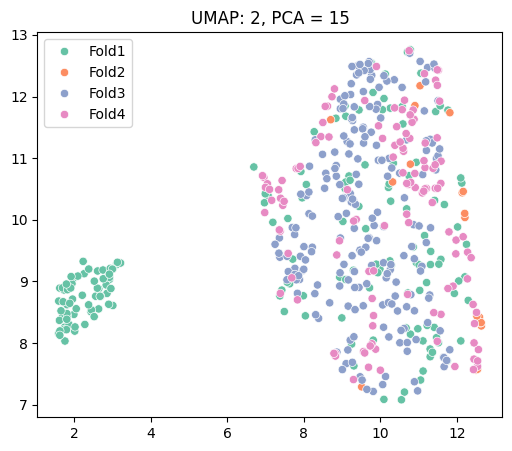

In [9]:
def plot_embedding(embedding, title):
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette='Set2')
    plt.title(title)
    plt.legend()
    plt.show()

plot_embedding(umap_pca_2, "UMAP: 2, PCA = 15")


In [10]:
from sklearn.metrics import confusion_matrix
from scipy.stats import entropy

def clustering_confusion_entropy(true_labels, pred_labels):

    cm = confusion_matrix(true_labels, pred_labels)
    print("Confusion Matrix (Counts):\n", pd.DataFrame(cm))

    #Normalize rows and columns for entropy calculation
    row_sums = cm.sum(axis=1, keepdims=True)
    col_sums = cm.sum(axis=0, keepdims=True)

    row_probs = np.divide(cm, row_sums, where=row_sums != 0)
    col_probs = np.divide(cm, col_sums, where=col_sums != 0)

    
    row_entropies = entropy(row_probs, axis=1) # entropy for each row
    row_weights = row_sums.flatten()
    row_weighted_entropy = np.average(row_entropies, weights=row_weights)
    
    
    col_entropies = entropy(col_probs, axis=0) # entropy for each column 
    col_weights = col_sums.flatten()
    col_weighted_entropy = np.average(col_entropies, weights=col_weights)

    # Output entropy metrics
    print("\nEntropy per True Label (Row):", row_entropies)
    print("Weighted Average Row Entropy:", row_weighted_entropy)

    print("\nEntropy per Cluster (Column):", col_entropies)
    print("Weighted Average Column Entropy:", col_weighted_entropy)

    return {
        "confusion_matrix": cm,
        "row_entropies": row_entropies,
        "row_weighted_entropy": row_weighted_entropy,
        "col_entropies": col_entropies,
        "col_weighted_entropy": col_weighted_entropy
    }


In [12]:

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

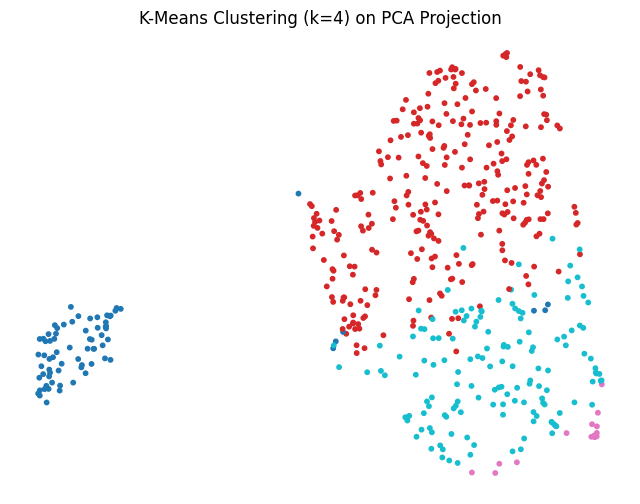

In [13]:
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=100, max_iter=1000)
kmeans_labels = kmeans.fit_predict(pca_result)
# Visualize clusters
plt.figure(figsize=(8, 6))
plt.scatter(umap_pca_2[:, 0], umap_pca_2[:, 1], c=kmeans_labels, cmap='tab10', s=10)
plt.title("K-Means Clustering (k=4) on PCA Projection")
plt.axis('off')
plt.show()

In [14]:
clustering_confusion_entropy(labels_encoded, kmeans_labels)

Confusion Matrix (Counts):
     0    1  2   3
0  74   54  4  42
1   0    9  3   6
2   0  140  1  67
3   0   87  6  30

Entropy per True Label (Row): [1.15656532 1.01140426 0.65703642 0.73640806]
Weighted Average Row Entropy: 0.854090648260234

Entropy per Cluster (Column): [0.         1.13352194 1.23965939 1.17340265]
Weighted Average Column Entropy: 0.9870362884761339


{'confusion_matrix': array([[ 74,  54,   4,  42],
        [  0,   9,   3,   6],
        [  0, 140,   1,  67],
        [  0,  87,   6,  30]], dtype=int64),
 'row_entropies': array([1.15656532, 1.01140426, 0.65703642, 0.73640806]),
 'row_weighted_entropy': 0.854090648260234,
 'col_entropies': array([0.        , 1.13352194, 1.23965939, 1.17340265]),
 'col_weighted_entropy': 0.9870362884761339}

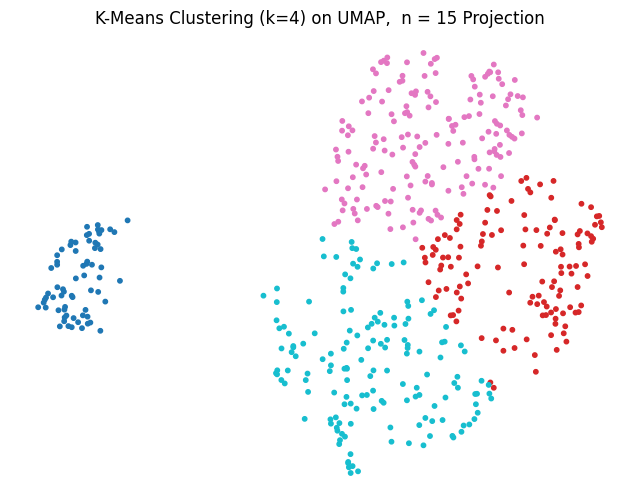

In [15]:
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=100, max_iter=1000)
kmeans_labels = kmeans.fit_predict(umap15)

# Visualize clusters
plt.figure(figsize=(8, 6))
plt.scatter(umap15[:, 0], umap15[:, 1], c=kmeans_labels, cmap='tab10', s=10)
plt.title("K-Means Clustering (k=4) on UMAP,  n = 15 Projection")
plt.axis('off')
plt.show()


In [16]:
clustering_confusion_entropy(labels_encoded, kmeans_labels)

Confusion Matrix (Counts):
     0   1   2   3
0  68  27  32  47
1   0   2   8   8
2   0  74  73  61
3   0  26  59  38

Entropy per True Label (Row): [1.32127021 0.96496292 1.09490509 1.04378197]
Weighted Average Row Entropy: 1.1537204405315016

Entropy per Cluster (Column): [0.         1.03357041 1.18634721 1.22796527]
Weighted Average Column Entropy: 1.006671042642598


{'confusion_matrix': array([[68, 27, 32, 47],
        [ 0,  2,  8,  8],
        [ 0, 74, 73, 61],
        [ 0, 26, 59, 38]], dtype=int64),
 'row_entropies': array([1.32127021, 0.96496292, 1.09490509, 1.04378197]),
 'row_weighted_entropy': 1.1537204405315016,
 'col_entropies': array([0.        , 1.03357041, 1.18634721, 1.22796527]),
 'col_weighted_entropy': 1.006671042642598}

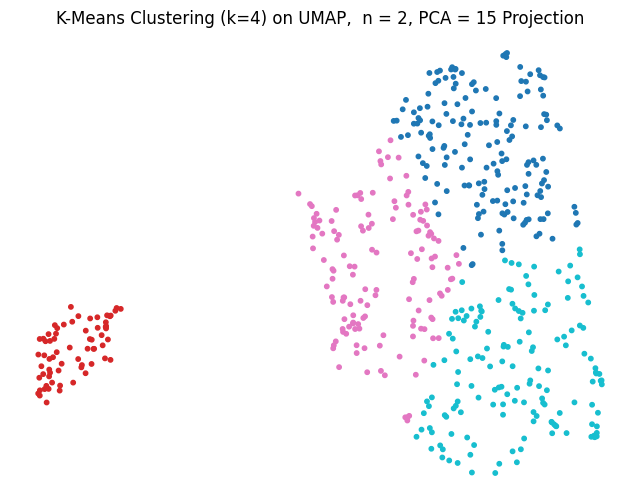

In [17]:
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=100, max_iter=1000)
kmeans_labels = kmeans.fit_predict(umap_pca_2)

# Visualize clusters
plt.figure(figsize=(8, 6))
plt.scatter(umap_pca_2[:, 0], umap_pca_2[:, 1], c=kmeans_labels, cmap='tab10', s=10)
plt.title("K-Means Clustering (k=4) on UMAP,  n = 2, PCA = 15 Projection")
plt.axis('off')
plt.show()


In [18]:
clustering_confusion_entropy(labels_encoded, kmeans_labels)

Confusion Matrix (Counts):
     0   1   2   3
0  31  67  30  46
1   8   0   0  10
2  74   0  74  60
3  53   0  33  37

Entropy per True Label (Row): [1.32962177 0.68696158 1.09396929 1.07710969]
Weighted Average Row Entropy: 1.154396942566211

Entropy per Cluster (Column): [1.18418403 0.         1.00814525 1.24999353]
Weighted Average Column Entropy: 1.0056203788639855


{'confusion_matrix': array([[31, 67, 30, 46],
        [ 8,  0,  0, 10],
        [74,  0, 74, 60],
        [53,  0, 33, 37]], dtype=int64),
 'row_entropies': array([1.32962177, 0.68696158, 1.09396929, 1.07710969]),
 'row_weighted_entropy': 1.154396942566211,
 'col_entropies': array([1.18418403, 0.        , 1.00814525, 1.24999353]),
 'col_weighted_entropy': 1.0056203788639855}